# Sumarização de textos longos

ref.: https://python.langchain.com/docs/tutorials/summarization/

In [1]:
from langchain_ollama import ChatOllama
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.runnables import RunnableConfig

import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
from IPython.display import Image

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Utilização do llama3.2 com interface via ollama

In [2]:
# Inicialize o modelo ChatOllama
llm = ChatOllama(model="llama3.2")

In [3]:
# Função para ler o conteúdo de um arquivo .txt
def load_text_from_file(file_path: str) -> List[Document]:
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return [Document(page_content=content)]

# Carrega o arquivo .txt
docs = load_text_from_file("./memorias_postumas_bras_cubas.txt")
len(docs[0].page_content)

359891

In [4]:
type(docs[0])

langchain_core.documents.base.Document

In [5]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=20_000, chunk_overlap=20
)
documents  = text_splitter.split_documents(docs)
print(f"Generated {len(documents)} documents.")

Generated 7 documents.


In [10]:
documents[0].page_content[:1000]

'MEMORIAS POSTHUMAS\nDE\nBRAZ CUBAS\nPOR\nMACHADO DE ASSIS\nRIO DE JANEIRO\nTYPOGRAPHIA NACIONAL\n1881\nÍNDICE\n\nOBRAS DO AUTOR\nMemorias Posthumas de Braz Cubas\nHelena, romance\nYayá Garcia, romance\nResurreição, romance\nA mão e a luva, romance\nHistorias da meia noite\nContos Fluminenses\nAmericanas, poesias\nPhalenas, poesias\nChrysalidas, poesias\nTu só, tu, puro amor, comédia\nOs deuses de casaca, comédia\nDesencantos, comédia\nTheatro\n\nAO LEITOR\nQue, no alto do principal de seus livros, confessasse Stendhal havel-o escripto para cem leitores, cousa é que admira e consterna. O que não admira, nem provavelmente consternará é se este outro livro não tiver os cem leitores de Stendhal, nem cincoenta, nem vinte, e quando muito, dez. Dez? Talvez cinco. Trata-se, na verdade, de uma obra diffusa, na qual eu, Braz Cubas, se adoptei a fórma livre de um Sterne, de um Lamb, ou de um de Maistre, não sei se lhe metti algumas rabugens de pessimismo. Póde ser. Obra de finado. Escrevi-a com 

In [7]:
# Initial summary
initial_prompt = """
Leia o seguinte trecho de um livro em português e faça um resumo claro e objetivo. No resumo:

1. Descreva brevemente quem são os personagens principais e o papel de cada um na história.
2. Apresente de maneira simples o enredo, explicando o que está acontecendo no trecho, sem citar o nome do livro.
3. Use uma linguagem acessível para que mesmo uma pessoa leiga consiga entender do que se trata a história.

Segue o trecho do livro: 

{context}.
"""

summarize_prompt = ChatPromptTemplate(
    [
        ("human", initial_prompt),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Leia o seguinte trecho de um livro em português e faça um resumo claro e objetivo. No resumo:

1. Descreva brevemente quem são os personagens principais e o papel de cada um na história.
2. Apresente de maneira simples o enredo, explicando o que está acontecendo no trecho, sem citar o nome do livro.
3. Use uma linguagem acessível para que mesmo uma pessoa leiga consiga entender do que se trata a história.

Resumo atual até o momento:
{existing_answer}

Novo trecho:
------------
{context}
------------
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()


# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

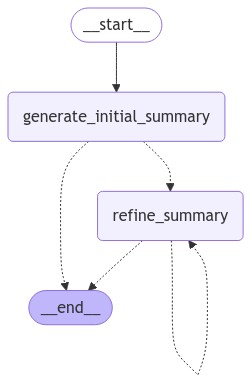

In [8]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [9]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in documents]},
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary)
        print("#"*20)

A narrativa apresentada é um exemplo clássico da literatura portuguesa do século XIX, caraterizada por uma prosa detalhada e observacional, bem como por uma crítica social e política. A história é contada sob a perspectiva de um jovem que se sente marginalizado e excluído da sociedade dos adultos.

A cena principal se desenrola em um jantar de família, onde o Dr. Villaça, um homem grave e medido, é o centro das atenções. Ele é o glosador, responsável por fazer a leitura das notícias e histórias, mas suas palavras são lidas de forma lentinha e monotona, o que provoca frustração no narrador.

O narrador, por sua vez, está fascinado pela tia Emerenciana, uma mulher mais jovem e dinâmica, que parece viver a vida com mais entusiasmo. No entanto, quando ela tenta fazer com que o Dr. Villaça seja mais rápido na leitura das notícias, ele se recusa a mudar, o que faz com que o narrador se sinta ainda mais excluído.

A cena também destaca a relação do narrador com sua tia Emerenciana, que é apre